# Setup

## Imports

In [14]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Machine Learning
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans

## Configurations and Functions

In [15]:
# Defining plot standard parameters
plt.rcParams.update({
    "axes.labelcolor": "#595959",
    "axes.facecolor": (0, 0, 0, 0),
    "axes.grid": False,
    "axes.labelpad": 6,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (9.25, 2.5),
    "figure.facecolor": (0, 0, 0, 0),
    "figure.dpi": 100,
    "legend.edgecolor": "#D9D9D9",
    "legend.borderaxespad": 0,
    "legend.framealpha": None,
    "legend.fontsize": 10,
    "legend.loc": "upper right",
    "legend.title_fontsize": 9,
    "text.color": "#595959",
    "xtick.color": "#D9D9D9",
    "xtick.labelcolor": "#595959",
    "ytick.color": "#D9D9D9",
    "ytick.labelcolor": "#595959"
})

# Ingesting Data

In [16]:
# List of report files
data_path = "../data/processed/rfm_standard.csv"

# Load data
df = pd.read_csv(data_path)

# Using a transformation technique

In [17]:
df = (
    df
    .assign(recency_transformed=PowerTransformer(method="box-cox").fit_transform(df[["recency"]]))
    .assign(frequency_transformed=PowerTransformer(method="box-cox").fit_transform(df[["frequency"]]))
    .assign(monetary_transformed=PowerTransformer(method="box-cox").fit_transform(df[["monetary"]]))
)

# Applying K-Means

In [18]:
%%capture
X = df.loc[:, ["recency_transformed","frequency_transformed","monetary_transformed",]]
optimal_k_value = KElbowVisualizer(estimator=KMeans(random_state=42,), k=(2,11), metric="distortion",)
transformed_model = KMeans(n_clusters=optimal_k_value.fit(X).elbow_value_, random_state=42)
transformed_model.fit(X)
df = (
    df
    .assign(rfm_transformed_clusters=transformed_model.labels_.astype(str))
    .assign(rfm_transformed_clusters=lambda x: x["rfm_transformed_clusters"].map({
            "0": "Can't Lose Them",
            "1": "Champions",
            "2": "Hibernating",
            "3": "New Customers",
        })
    )
)

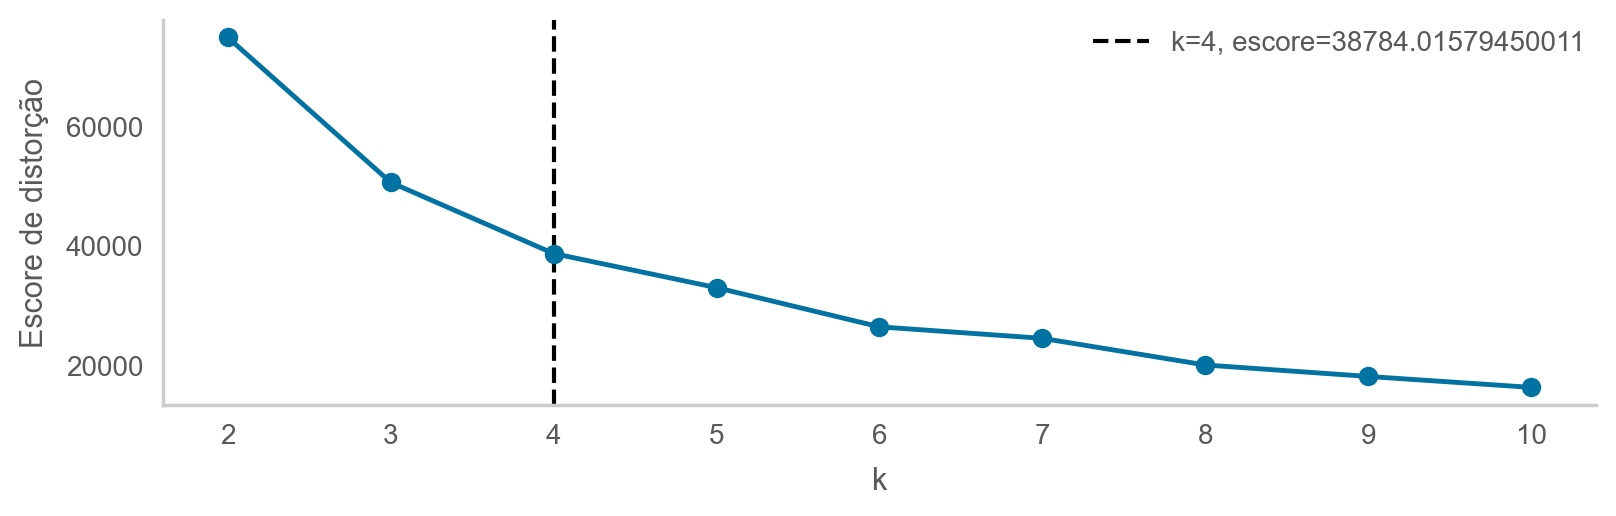

In [26]:
fig, ax = plt.subplots(dpi=200)
ax.plot(optimal_k_value.k_values_, optimal_k_value.k_scores_, marker='o', label='Distortion Score')
ax.set_xlabel("k")
ax.set_ylabel("Escore de distorção")
vline = ax.axvline(x=optimal_k_value.elbow_value_, color="black", linestyle='--', linewidth=1.5, zorder=1, label=f"k={optimal_k_value.elbow_value_}, escore={optimal_k_value.elbow_score_}")
plt.legend(handles=[vline]);

In [20]:
fig = px.scatter_3d(
    df, 
    x="recency_transformed", 
    y="frequency_transformed",
    z="monetary_transformed",
    color="rfm_transformed_clusters",
    opacity=0.8,
)

fig.update_traces(marker=dict(size=3))

fig.update_layout(
    scene=dict(
        xaxis_title='Recência',
        yaxis_title='Frequência',
        zaxis_title='Monetário'
    ),
    legend_title_text='RFM (transformado)',
    width=1000,  # Width in pixels
    height=700  # Height in pixels
)

fig.show()

In [21]:
fig = px.scatter_3d(
    df, 
    x="recency", 
    y="frequency",
    z="monetary",
    color="rfm_transformed_clusters",
    opacity=0.8,
)

fig.update_traces(marker=dict(size=3))

fig.update_layout(
    scene=dict(
        xaxis_title='Recência',
        yaxis_title='Frequência',
        zaxis_title='Monetário'
    ),
    legend_title_text='RFM',
)
fig.show()

In [22]:
pd.options.display.float_format = '{:.2f}'.format

df.groupby("rfm_transformed_clusters").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary": ["mean", "sum"],
    "client_hash": "count"
})

recency frequency monetary            client_hash
                            mean      mean     mean        sum       count
rfm_transformed_clusters                                                  
Can't Lose Them           493.26      1.00   378.82 3517764.47        9286
Champions                 298.88      2.60   638.68 6280107.63        9833
Hibernating               482.75      1.00   137.92 2237952.91       16226
New Customers             170.20      1.00   238.40 2513703.68       10544

## Notas

### Hipótese
1. Uma técnica de transformação de distribuição de dados pode melhorar os resultados de clustering.

### Evidências
1. A pontuação de distorção é de 32k contra 42k do modelo inicial de clustering. Um número menor indica uma melhor separação dos clusters.
2. A análise visual indica que todas as dimensões foram consideradas no processo de clustering.
3. Os dados transformados ajudam na interpretação dos resultados de clustering.

### Conclusões
1. O modelo de clustering com transformação apresentou melhores resultados. Este será usado como o modelo de clustering RFM.

## Resultados Finais

O modelo de clustering RFM dividiu os clientes em 5 clusters.

## 🔴 Cluster "Hibernating" (16004 clientes)

### Definição
Clientes que compraram um valor pequeno há muito tempo e realizaram apenas uma única compra.

### Métricas
- Recência (média): 485 dias.
- Frequência (média): 1 compra.
- Valor monetário (média): R$ 137,00.

### Ações sugeridas
Há uma grande probabilidade de que esses clientes gerem um baixo ROI (Retorno sobre Investimento) em esforços de marketing. Entretanto, se a empresa decidir investir, 
uma boa estratégia para este grupo é mudar o foco deixado em transações para a criação de valor de marca.

- Compartilhar um vídeo de alto nível que aborde a missão/essência da marca.
- Compartilhar um post de blog ou guia que ajude a entender melhor a marca.
- Conteúdo como “conheça o fundador” ou “conheça a marca”.

## 🟢 Cluster "At Risk" (9137 clientes)

### Definição
Clientes com alto potencial de gasto em compras (dimensão monetária alta) mas que compraram apenas uma vez e há muito tempo.

### Métricas
- Recência (média): 494 dias.
- Frequência (média): 1 compra.
- Valor monetário (média): R$ 380,00.

### Ações sugeridas
Este grupo experimentou a marca, mas não voltou para uma segunda compra por algum motivo. É importante investigar o porquê e tentar reengajar, mesmo que seja algo desafiador.

- Realizar pesquisas ou coletar feedback para entender por que não compraram novamente e resolver possíveis preocupações.
- Compartilhar conteúdo sobre novos produtos e a evolução da marca.
- Criar descontos e promoções com o único foco de fazê-los repetir uma compra, mesmo que seja de baixa margem (como Leve 1, Ganhe 1).
- Preços especiais em pacotes, combinando produtos que eles já testaram com novos produtos complementares.

## 🔵 Cluster "New Customers" (10859 clientes)

### Definição
Clientes que fizeram apenas uma compra recentemente com valor monetário variável.

### Métricas
- Recência (média): 174 dias.
- Frequência (média): 1 compra.
- Valor monetário (média): R$ 236,00.

### Ações sugeridas
Esse grupo já “testou” a marca. Foque em criar uma boa impressão.

- Compartilhar conteúdo sobre a história da marca e produtos, preparando-os para futuras coleções.
- Investir em grandes descontos para a próxima compra deste grupo.
- Implementar uma série de e-mails de boas-vindas para apresentar produtos/serviços.
- Convidar a seguir a marca em redes sociais ou assinar uma newsletter com conteúdo de estilo e marca.

## 🟠 Cluster "Can't Lose Them" (5454 clientes)

### Definição
Clientes que realizaram mais de uma compra, gastaram um valor monetário alto, mas não compram há um bom tempo.

### Métricas
- Recência (média): 428 dias.
- Frequência (média): 2 compras.
- Valor monetário (média): R$ 550,00.

### Ações sugeridas
Este grupo tem alto potencial de crescimento e importância para a sustentabilidade do negócio. Concentre-se em reengajá-los.

- Criar um incentivo que eles possam desbloquear ao participar da sua comunidade.
- Mostrar os últimos lançamentos (ou avisar quando serão lançados).
- Promover incentivos para que baixem o aplicativo da empresa.
- Chamar atenção com um grande desconto e/ou personalização.

## 🟣 Cluster "Champions" (4400 clientes)

### Definição
Clientes que realizaram mais de uma compra, gastaram um valor monetário alto e compraram recentemente.

### Métricas
- Recência (média): 139 dias.
- Frequência (média): 3 compras.
- Valor monetário (média): R$ 750,00.

### Ações sugeridas
Este grupo é o mais importante para o negócio. Faça-os se sentirem especiais.

- Ofertas exclusivas e personalizadas.
- Acesso antecipado a novas coleções.
- Mostrar os últimos lançamentos (ou avisar quando serão lançados).
- Promover incentivos para baixar o aplicativo da empresa.

# Exporting data

In [23]:
df.to_csv("../data/processed/rfm_kmeans_with_transformation.csv", index=False)